In [1]:
# import packages
from collections import OrderedDict
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import sklearn.datasets
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from itertools import chain
from tqdm import tqdm_notebook as tqdm
from tqdm import trange

In [2]:
## define neural nets for each model
class EncoderW(nn.Module):
    
    '''
    This class transforms the images and labels into a vector in the latent space, W. 
    Requires input and output dimensions. 
    Example: 
    Input dimension: 3 (features) + 1 (label)
    Output dimension: 2 (n_dimensions in the latent space)
    '''
    
    def __init__(self, dim_in, dim_out, n_units = 32):
        super().__init__()
        self.dim_out = dim_out
        
        # modelling choice is to implement fully connected layers - this can be changed to CNNs when using images
        self.model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(dim_in, n_units)), ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(n_units, n_units)), ('relu2', nn.ReLU()), 
            ('final_linear', nn.Linear(n_units, 2 *dim_out))
        ]))

    def forward(self, x, y):
        # pass x and y concatenated into the model
        out = self.model(torch.cat((x, y), dim=-1))
        # separate out components - mean and logvar
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:] # mean field assumption 
        # generate samples
        samples = torch.randn_like(mu) * torch.exp(0.5 * logvar) + mu
        return mu, logvar, samples

class EncoderZ(nn.Module):
    
    '''
    This class transforms the images into a vector in the latent space, Z. 
    Requires input and output dimensions. 
    Example: 
    Input dimension: 3 (features)
    Output dimension: 2 (n_dimensions in the latent space)
    '''
    def __init__(self, dim_in, dim_out, n_units = 32):
        super().__init__()
        self.dim_out = dim_out
        
        # modelling choice is to implement fully connected layers - this can be changed to CNNs when using images
        self.model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(dim_in, n_units)), ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(n_units, n_units)), ('relu2', nn.ReLU()), 
            ('final_linear', nn.Linear(n_units, 2 *dim_out))
        ]))

    def forward(self, x):
        # pass x into the model
        out = self.model(x)
        # separate out components - mean and logvar
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:]  # mean field assumption 
        # generate samples
        samples = torch.randn_like(mu) * torch.exp(0.5 * logvar) + mu 
        return mu, logvar, samples

    
class DecoderX(nn.Module):
    '''
    This class transforms the images and labels into a vector in the latent space, W. 
    Requires input and output dimensions. 
    Example: 
    Input dimension: 2 (latent dims from Z) + 2 (latent dims from W)
    Output dimension: 3 dimensions of original data
    '''
    def __init__(self, dim_in, dim_out, n_units = 32):
        super().__init__()
        self.dim_out = dim_out
        
        # modelling choice is to implement fully connected layers - this can be changed to CNNs when using images
        self.fcs = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(dim_in, n_units)), ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(n_units, n_units)), ('relu2', nn.ReLU()), 
            ('final_linear', nn.Linear(n_units, 2 *dim_out))
        ]))

    def forward(self, w, z):
        # pass w and z concatenated into the model
        out = self.fcs(torch.cat((w, z), dim=-1))
        # separate out components - mean and logvar        
        mu = out[:, :self.dim_out]
        logvar = out[:, self.dim_out:] 
        # generate samples
        sample = torch.randn_like(mu) * torch.exp(0.5 * logvar) + mu
        return mu, logvar, sample


class DecoderY(nn.Module):
    
    '''
    This class transforms the images and labels into a vector in the latent space, W. 
    Requires input and output dimensions. 
    Example: 
    Input dimension: 3 (features) + 1 (label)
    Output dimension: 2 (dimensions in the latent space)
    '''
    def __init__(self, dim_in, n_classes, n_units = 32):
        super().__init__()
        
        # modelling choice is to implement fully connected layers - this can be changed to CNNs when using images
        self.model = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(dim_in, n_units)), ('relu1', nn.ReLU()),
            ('linear2', nn.Linear(n_units, n_units)), ('relu2', nn.ReLU()), 
            ('final_linear', nn.Linear(n_units, n_classes))
        ]))

    def forward(self, z):
        # pass z into the model
        linear_output = self.model(z)
        # softmax the output to get probability of class 1
        out = F.softmax(linear_output, dim=-1)
        return out

In [3]:
def KL(mu1, logvar1, mu2, logvar2):
    '''
    Calculates the KL divergence between two gaussians
    See appendix here for a generalized version of this formula: https://arxiv.org/pdf/1312.6114.pdf
    '''
    std1 = torch.exp(0.5 * logvar1)
    std2 = torch.exp(0.5 * logvar2)
    return torch.sum(torch.log(std2) - torch.log(std1) + 0.5 * (torch.exp(logvar1) + (mu1 - mu2) ** 2) / torch.exp(logvar2) - 0.5, dim=-1)

In [4]:
# Generate swiss roll data
X_, _ = sklearn.datasets.make_swiss_roll(n_samples=100000, random_state=207)
X_ = X_.astype(np.float32)
y_ = (X_[:, 1] < 10).astype(np.int32)
print('Swiss roll data has dimensions {}.\nLabels are generated based on the second dimension have dimensions {}.'.format(X_.shape, y_.shape))

Swiss roll data has dimensions (100000, 3).
Labels are generated based on the second dimension have dimensions (100000,).


In [5]:
# Initialize all neural networks (nn) defined above
encoder_w = EncoderW(dim_in=4, dim_out=2) # nn to encode data and labels into 2 dimensions
encoder_z = EncoderZ(dim_in=3, dim_out=2) # nn to encode data only into 2 dimensions
decoder_x = DecoderX(dim_in=4, dim_out=3) # nn to decode the sampled vectors from W and Z to generated data
decoder_y = DecoderY(dim_in=2, n_classes=2) # nn to decode the sampled vector Z to a label

In [6]:
## define two optimizers for the two components of the loss:
## 1. relating to maximizing the elbo 
optimizer1 = torch.optim.Adam(chain(decoder_x.parameters(),
    encoder_w.parameters(),
    encoder_z.parameters()), lr=1e-3)

## 2. relating to learning the approximate posterior
optimizer2 = torch.optim.Adam(decoder_y.parameters(), lr=1e-3)

In [ ]:
# use dataloader to train in batches
trainloader = torch.utils.data.DataLoader(list(zip(X_, y_)), shuffle=True, batch_size=256)

# run training cycle
with trange(20) as t:
    for i in t:
        t.set_description('Epoch %d' % i)
        # training by batch_size
        for x, y in trainloader:
            
            # FORWARD PASS: 
            
            # encode x to get mean, log variance, and samples from the latent subspace Z
            mu_z, logvar_z, z = encoder_z(x)
            # encode x and y to get mean, log variance, and samples from the latent subspace W
            mu_w, logvar_w, w = encoder_w(x, y.unsqueeze(-1).float())

            # pass smaples of z and w to get mean, logvar and predictions of x - modelling it as Gaussina
            mu_x, logvar_x, pred_x = decoder_x(w, z)
            # get predicted labels based only on the latent subspace Z
            pred_y = decoder_y(z)
            
            # define two KL divergences:
            # KL divergence for label 1
            #    We want the latent subspace W for this label to be close to mean 0, var 0.01
            kl1 = KL(mu1=mu_w, logvar1=logvar_w, 
                     mu2 = torch.zeros_like(mu_w), logvar2 = torch.ones_like(logvar_w) * np.log(0.01))
            # KL divergence for label 0
            #    We want the latent subspace W for this label to be close to mean 3, var 0
            kl0 = KL(mu_w, logvar_w, torch.ones_like(mu_w) * 3., torch.ones_like(logvar_w) * np.log(0.01))
            
            # OPTIMIZATION: 
            
            # Specified in section 4.1 of http://www.cs.toronto.edu/~zemel/documents/Conditional_Subspace_VAE_all.pdf
            # There are three components: M1, M2, N
            
            # 1.Optimize the first loss related to maximizing variational lower bound 
            #   on the marginal log likelihood and minimizing mutual information 
            optimizer1.zero_grad()
            
            loss1 = (20. * torch.sum((x - mu_x) ** 2, -1)  ## corresponds to M1
                + 1. * torch.where(y == 1, kl1, kl0)  ## corresponds to M1
                + 20000 * KL(mu_z, logvar_z, torch.zeros_like(mu_z), torch.zeros_like(logvar_z))  ## corresponds to M1
                + 20. * torch.sum(pred_y * torch.log(pred_y), -1)).sum()  # corresponds to M2
            loss1.backward(retain_graph=True)
            optimizer1.step()

            # 2. Optimize second loss related to learning the approximate posterior
            optimizer2.zero_grad()
            loss2 = (100. * torch.where(y == 1, -torch.log(pred_y[:, 1]), -torch.log(pred_y[:, 0]))).sum()
            loss2.backward()
            optimizer2.step()
    
            # combine losses for tracking
            loss = loss1 + loss2
        
        t.set_postfix(loss=loss.item(), y_max=pred_y.max().item(), y_min=pred_y.min().item())
        # print(loss.item()) # uncomment to print loss per epoch

Epoch 4:  20%|██        | 4/20 [00:12<00:49,  3.09s/it, loss=4.68e+4, y_max=0.538, y_min=0.462]

In [8]:
# Data Generation Process
with torch.no_grad():
    z_, _1, _2 = encoder_z(torch.from_numpy(X_))
    w_, _3, _4 = encoder_w(torch.from_numpy(X_), torch.from_numpy(y_).unsqueeze(-1).float())
    pred_x, _5, _6 = decoder_x(w_, z_)
    pred_y = decoder_y(z_)
    pred_x = pred_x.cpu().numpy()
    pred_y = pred_y.cpu().numpy()    

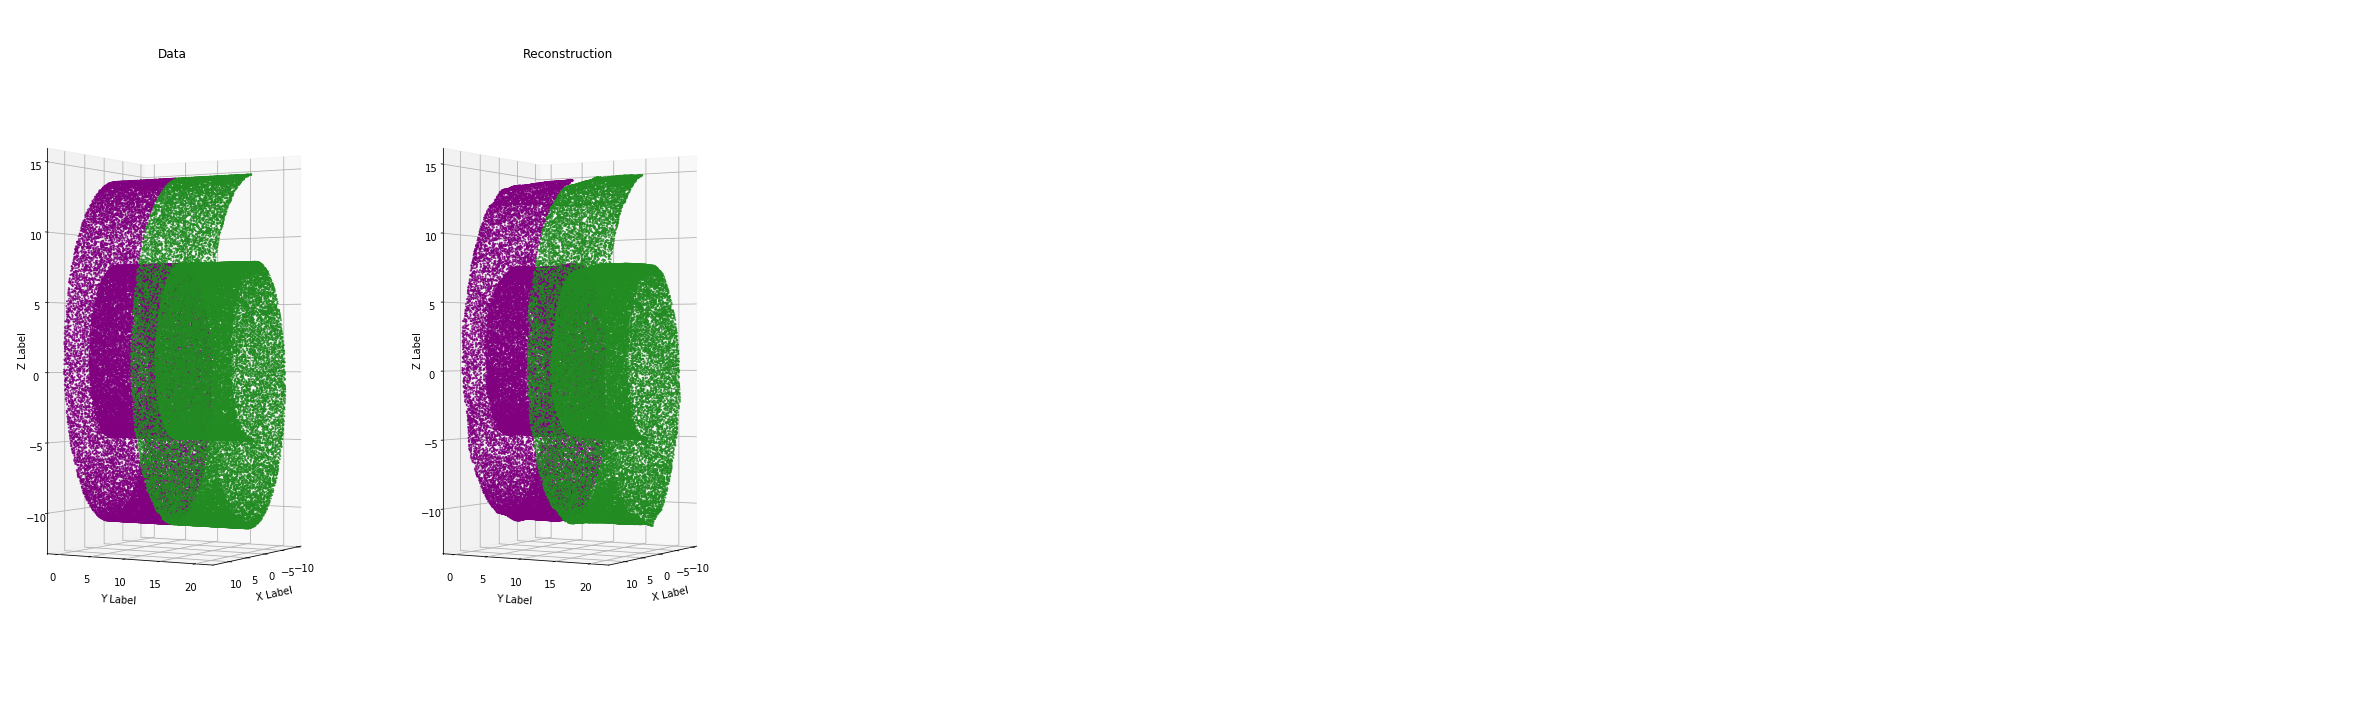

In [9]:
fig = plt.figure(figsize = (13,13))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(X_[y_ == 0, 0], X_[y_ == 0, 1], X_[y_ == 0, 2], s = 1, c = 'forestgreen', alpha = 0.7)
ax.scatter(X_[y_ == 1, 0], X_[y_ == 1, 1], X_[y_ == 1, 2], s = 1, c = 'purple', alpha = 0.7)
ax.view_init(0,30)
ax.set_title('Data')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# plt.show()
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.scatter(pred_x[y_ == 0, 0], pred_x[y_ == 0, 1], pred_x[y_ == 0, 2], s = 1, c = 'forestgreen', alpha = 0.7)
ax.scatter(pred_x[y_ == 1, 0], pred_x[y_ == 1, 1], pred_x[y_ == 1, 2], s = 1, c = 'purple', alpha = 0.7)
ax.view_init(0,30)
ax.set_title('Reconstruction')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

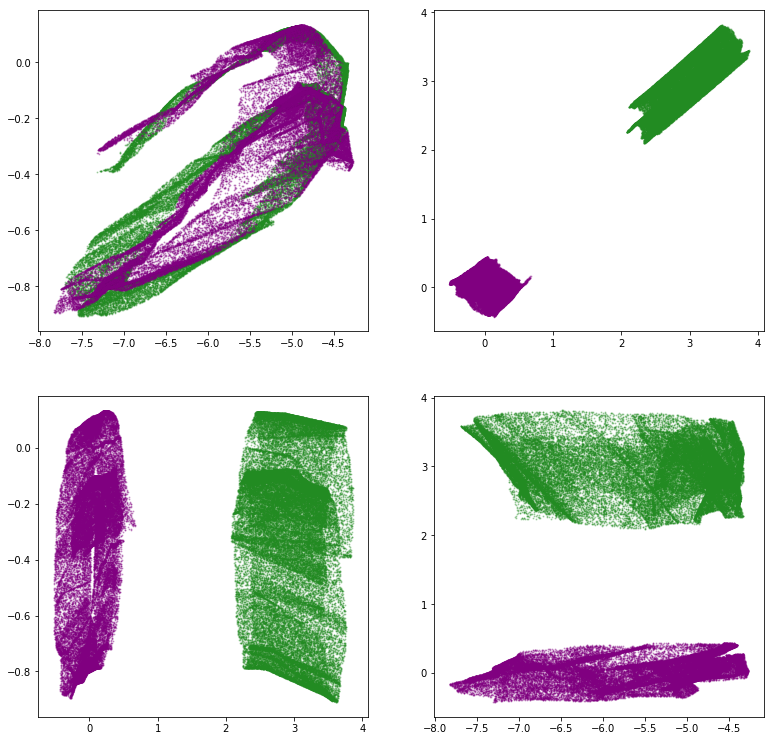

In [52]:
fig1 = plt.figure(figsize = (13,13))
plt.subplot(2,2,1)
plt.scatter(z_[y_ == 0, 0], z_[y_ == 0, 1], s=1, c='forestgreen', alpha=0.3)
plt.scatter(z_[y_ == 1, 0], z_[y_ == 1, 1], s=1, c='purple', alpha=0.3)

plt.subplot(2,2,2)
plt.scatter(w_[y_ == 0, 0], w_[y_ == 0, 1], s=1, c='forestgreen', alpha=0.3)
plt.scatter(w_[y_ == 1, 0], w_[y_ == 1, 1], s=1, c='purple', alpha=0.3)

plt.subplot(2,2,3)
plt.scatter(w_[y_ == 0, 0], z_[y_ == 0, 1], s=1, c='forestgreen', alpha=0.3)
plt.scatter(w_[y_ == 1, 0], z_[y_ == 1, 1], s=1, c='purple', alpha=0.3)
plt.xlabel('')

plt.subplot(2,2,4)
plt.scatter(z_[y_ == 0, 0], w_[y_ == 0, 1], s=1, c='forestgreen', alpha=0.3)
plt.scatter(z_[y_ == 1, 0], w_[y_ == 1, 1], s=1, c='purple', alpha=0.3)

plt.show()